# Intalar paquetes, Abrir data y ajustarla

In [3]:
# =============================================================================
# Importar paquetes y abrir Data
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from geopandas import *
from plotnine import *

#para ajustar las fechas
import datetime

#para calcular el skew de un array() o list()
from scipy.stats import skew 

col_names=pd.read_csv("Data/(column)Facturac_2017_2020.csv",
                    encoding="utf-8",sep=";",nrows=0).columns
types_dict = {col: str for col in col_names}

Data = pd.read_csv("Data/(column)Facturac_2017_2020.csv",
                   encoding="utf-8",sep=";",dtype=types_dict)

In [4]:
Data=Data[Data['Zona de ventas.1']=='Temuco']
Data.describe(include='all')

,Material,Tipo de cliente,Zona de ventas,Zona de ventas.1,Oficina de Ventas Unifica,Oficina de Ventas Unifica.1,Subtipo de cliente,Cluster,Cliente - Local,Cliente - Local.1,Mes,Año natural/Semana,Día natural,Día de la semana,Kilos Venta KG,Venta Neta CLP,Precio Promedio CLP
count,3873,3873,3873,3873,3873,3873,3873,3873,3873,3873,3873,3873,3873,3873,3873,3873,3873
unique,1,1,1,1,1,87,5,3,324,329,12,227,1092,6,254,3760,542
top,Tradicional,Z004,Sur,Temuco,T105,8000580048,Espec. en Crudos,Clásico,Los Camperos Temuco,58651,2,16.2021,28.11.2019,VI,20,44.574,2.500
freq,3873,3873,3873,3873,3873,352,2900,2101,297,297,487,56,19,864,252,3,282


In [5]:
# =============================================================================
# Ajustar la data
# =============================================================================
def Ajuste_data(data):
    df=data.copy()
    # Funciones para eliminar los putos y cambiar las , por .
    def change_num_point(x):
        x=str(x)
        return x.replace('.', '')
    def change_num_coma(x):
        x=str(x)
        return x.replace(',', '.')
    for i in ['Kilos Venta KG','Venta Neta CLP','Precio Promedio CLP']:
        df[i]=df[i].apply(change_num_point)
        df[i]=df[i].apply(change_num_coma)
        df[i]=df[i].astype('int64')

        #Separacion fecha
    df['Semana']=df['Año natural/Semana'].str.split('.', expand=True)[[0]]
    df['Año']=df['Año natural/Semana'].str.split('.', expand=True)[[1]]

    df['Semana']=df['Semana'].astype('int64')
    df['Año']=df['Año'].astype('int64')
    
    #
    df["Día natural"] = df["Día natural"].apply(lambda x: 
                                                datetime.datetime.strptime(x,
                                                                           '%d.%m.%Y').date())
    return df

In [6]:
data=Ajuste_data(Data)

In [7]:
df=data.copy()
df.iloc[2]['Día natural']#-df.iloc[1]['Día natural']

datetime.date(2021, 4, 26)

# Data Clientes 

In [10]:
col_client='Cliente - Local.1'

# Creamos la Data clientes para almacenar las caracteristicas de los clientes
D_Clientes=data[col_client].unique()#.to_list()

# Frecuencia
## Generalización

In [12]:
def frec_cliente(D_Clientes,i):
    id_client=D_Clientes[i]
    
    
    df_i=data[data[col_client]==id_client].copy()
    #-------------------------------------------
    #primer año
    #int((str(df_i['Día natural'].min()))[:4])
    ano_in=df_i['Día natural'].min().year
    
    #primer mes
    #int((str(df_i['Día natural'].min()))[5:7])
    mes_in=df_i['Día natural'].min().month
    
    
    #---------------------------------------------------------------------------
    # values
    date_v=list(df_i.groupby(['Mes','Año'],
                             sort=True).count()['Kilos Venta KG'])

    #index
    date_i=list((df_i.groupby(['Mes','Año'],
                              sort=True).count()['Kilos Venta KG']).index)
    date_i
    
    
    #------------------------------
    #
    #------------------------------
    fechas=list()
    for a in range(ano_in,2022):
        if a==ano_in:
            for m in range(mes_in,13):
                t=tuple((str(m),a))
                fechas.append(t)     
        elif(a==2021):
            for m in range(1,3):
                t=tuple((str(m),a))
                fechas.append(t)
        else:
            for m in range(1,13):
                t=tuple((str(m),a))
                fechas.append(t)

    return ((pd.merge(pd.DataFrame({'Date':fechas}),
                    pd.DataFrame({'Date':date_i,'Frecuencia':date_v})
                 , how='left'))['Frecuencia'].sum()/len(fechas))

In [13]:
frec_cliente(D_Clientes,1)

0.8461538461538461

In [14]:
Client_frec=list()#[ i for i in range(len(D_Clientes))]
for i in range(len(D_Clientes)):
    Client_frec.append(frec_cliente(D_Clientes,i))

In [16]:
Client_frec[:20]

[0.6666666666666666,
 0.8461538461538461,
 0.3888888888888889,
 0.08695652173913043,
 0.9411764705882353,
 0.17391304347826086,
 0.09090909090909091,
 0.03225806451612903,
 0.9183673469387755,
 0.023255813953488372,
 0.14285714285714285,
 0.7755102040816326,
 0.022222222222222223,
 0.42857142857142855,
 0.05263157894736842,
 0.07894736842105263,
 0.30303030303030304,
 0.28,
 0.5681818181818182,
 0.16666666666666666]

## Incorpora la frec a un df 

In [17]:
col_client='Cliente - Local.1'

# Creamos la Data clientes para almacenar las caracteristicas de los clientes
D_Clientes=pd.DataFrame({col_client:data[col_client].unique()
                        })
D_Clientes[col_client]=D_Clientes[col_client].astype('category')
D_Clientes.shape

(329, 1)

In [18]:
df_clientes=pd.DataFrame({col_client:D_Clientes[col_client],
                          'Frecuencia mes promedio':Client_frec})
df_clientes.describe(include='all')

,Cliente - Local.1,Frecuencia mes promedio
count,329,329.000000
unique,329,NaN
top,10343,NaN
freq,1,NaN
mean,NaN,0.376589
std,NaN,0.680929
min,NaN,0.020000
25%,NaN,0.071429
50%,NaN,0.166667
75%,NaN,0.404762


<AxesSubplot:>

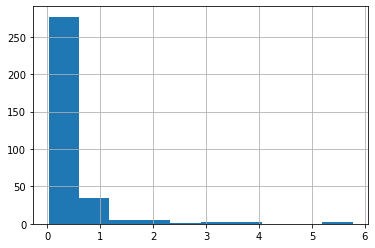

In [19]:
df_clientes['Frecuencia mes promedio'].hist()

# Delta pedido

## tomo a un cliente

In [20]:
D_Clientes.iloc[i,0]

'3200145770'

In [21]:
i=0
id_client=D_Clientes.iloc[i,0]
df_i=data[data[col_client]==id_client].copy()
df_i=df_i.sort_values(by=['Día natural'])
df_i.head(2)

,Material,Tipo de cliente,Zona de ventas,Zona de ventas.1,Oficina de Ventas Unifica,Oficina de Ventas Unifica.1,Subtipo de cliente,Cluster,Cliente - Local,Cliente - Local.1,Mes,Año natural/Semana,Día natural,Día de la semana,Kilos Venta KG,Venta Neta CLP,Precio Promedio CLP,Semana,Año
1020003,Tradicional,Z004,Sur,Temuco,T105,8000480112,Espec. en Crudos,Sin asignar,Castro Muñoz Jose Isaias,3200104287,4,15.2021,2021-04-12,LU,43,182668,4290,15,2021
1020003,Tradicional,Z004,Sur,Temuco,T105,8000480112,Espec. en Crudos,Sin asignar,Castro Muñoz Jose Isaias,3200104287,4,16.2021,2021-04-21,MI,43,157268,3690,16,2021


In [22]:
lote=list(df_i['Kilos Venta KG'])
dias=list(df_i['Día natural'])
dias
delta=list()
delta_mean=0
ratio_mean=0
if(len(dias)>1):
    for i in range(len(dias)-1):
        delta.append((dias[i+1] - dias[i]).days)
        ratio_mean+=delta[i]/lote[i]
        delta_mean+=((dias[i+1] - dias[i]).days)
    delta_mean=delta_mean/(len(delta))
    ratio_mean=ratio_mean/(len(delta))
else:
    delta_mean=-1
    ratio_mean=-1

array([[<AxesSubplot:title={'center':'lote'}>]], dtype=object)

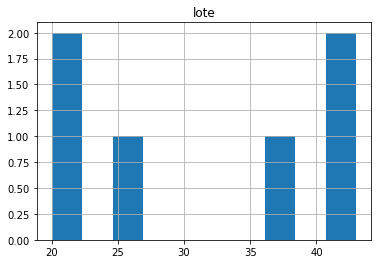

In [23]:
(pd.DataFrame({'lote':lote})).hist()

In [24]:
(pd.DataFrame({'lote':lote})).std()/(pd.DataFrame({'lote':lote})).mean()

lote    0.344704
dtype: float64

In [25]:
sum(lote)/len(lote)

31.5

In [26]:
delta_mean/sum(lote)/len(lote)

0.005643738977072311

In [27]:
ratio_mean

0.21519943915292755

In [28]:
delta_mean

6.4

In [29]:
skew(delta)

0.3169627324056571

In [30]:
Pedidos=pd.DataFrame({'Dias':dias[:len(dias)-1],'Pedido Kg':lote[:len(lote)-1],'delta':delta})
Pedidos

,Dias,Pedido Kg,delta
0,2021-04-12,43,9
1,2021-04-21,43,5
2,2021-04-26,20,9
3,2021-05-05,26,5
4,2021-05-10,37,4


In [31]:
def a():
    return(1,2,4)
a

<function __main__.a()>

## Función aplicable para todos los clientes

Entrega
* delta_mean
* skew_delta
* Lote_mean
* ratio_mean

In [32]:
def Atributos_cliente(D_Clientes,i):
    id_client=D_Clientes.iloc[i,0]    
    df_i=data[data[col_client]==id_client].copy()
    
    
    #se ordenan los dias de forma creciente
    #para tener los Delta bien configurados
    df_i=df_i.sort_values(by=['Día natural'])
    
    #########################################
    #
    #########################################
    lote=list(df_i['Kilos Venta KG'])
    dias=list(df_i['Día natural'])
    
    #inicio con valores cero
    delta=list()
    delta_mean=0
    ratio_mean=0
    # recorre todos los dias menos el ultimo
    #para generar los delta
    for i in range(len(dias)-1):
        delta.append((dias[i+1] - dias[i]).days)
        ratio_mean+=delta[i]/lote[i]
        delta_mean+=((dias[i+1] - dias[i]).days)
    #delta promedio
    if(len(delta)>0):
        delta_mean=delta_mean/(len(delta))
        ratio_mean=ratio_mean/(len(delta))
        skew_delta =skew(delta)
    else:
        delta_mean=delta_mean
        ratio_mean=ratio_mean
        skew_delta=0
    df_lote=pd.DataFrame({'lote':lote})
    
    return(delta_mean,skew_delta, sum(lote)/len(lote) ,
           (df_lote.std()['lote']/df_lote.mean()['lote']))

In [33]:
Atributos_cliente(D_Clientes,1)

(30.0, 1.9976983396258403, 31.466666666666665, 0.3701958655426317)

In [34]:
data[data[col_client]==D_Clientes.iloc[0,0]]

,Material,Tipo de cliente,Zona de ventas,Zona de ventas.1,Oficina de Ventas Unifica,Oficina de Ventas Unifica.1,Subtipo de cliente,Cluster,Cliente - Local,Cliente - Local.1,Mes,Año natural/Semana,Día natural,Día de la semana,Kilos Venta KG,Venta Neta CLP,Precio Promedio CLP,Semana,Año
1020003,Tradicional,Z004,Sur,Temuco,T105,8000480112,Espec. en Crudos,Sin asignar,Castro Muñoz Jose Isaias,3200104287,4,15.2021,2021-04-12,LU,43,182668,4290,15,2021
1020003,Tradicional,Z004,Sur,Temuco,T105,8000480112,Espec. en Crudos,Sin asignar,Castro Muñoz Jose Isaias,3200104287,4,16.2021,2021-04-21,MI,43,157268,3690,16,2021
1020003,Tradicional,Z004,Sur,Temuco,T105,8000480112,Espec. en Crudos,Sin asignar,Castro Muñoz Jose Isaias,3200104287,4,17.2021,2021-04-26,LU,20,69393,3390,17,2021
1020003,Tradicional,Z004,Sur,Temuco,T105,8000480112,Espec. en Crudos,Sin asignar,Castro Muñoz Jose Isaias,3200104287,5,18.2021,2021-05-05,MI,26,94489,3590,18,2021
1020003,Tradicional,Z004,Sur,Temuco,T105,8000480112,Espec. en Crudos,Sin asignar,Castro Muñoz Jose Isaias,3200104287,5,19.2021,2021-05-10,LU,37,141412,3849,19,2021
1020003,Tradicional,Z004,Sur,Temuco,T105,8000480112,Espec. en Crudos,Sin asignar,Castro Muñoz Jose Isaias,3200104287,5,19.2021,2021-05-14,VI,20,101463,5058,19,2021


In [ ]:
for i in range(len(D_Clientes)):
    
    X_a=Atributos_cliente(D_Clientes,i)

## iPArte iter

In [35]:
delta_mean=list()
skew_delta=list()
Lote_mean=list()
Lote_cov=list()
for i in range(len(D_Clientes)):
    X_a=Atributos_cliente(D_Clientes,i)
    delta_mean.append(X_a[0])
    skew_delta.append(X_a[1])
    Lote_mean.append(X_a[2])
    Lote_cov.append(X_a[3])

# Creación del CSV

In [36]:
df_clientes=pd.DataFrame({col_client:D_Clientes[col_client],
                          'Frecuencia mes promedio':Client_frec
                          ,'Delta dia promedio':delta_mean
                          ,'Skew Delta dia':skew_delta
                          ,'Kilos Venta promedio':Lote_mean
                          ,'Covarianza del lote':Lote_cov
                         })
df_clientes.describe(include='all')

,Cliente - Local.1,Frecuencia mes promedio,Delta dia promedio,Skew Delta dia,Kilos Venta promedio,Covarianza del lote
count,329,329.000000,329.000000,329.000000,329.000000,217.000000
unique,329,NaN,NaN,NaN,NaN,NaN
top,10343,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.376589,70.733936,0.772455,48.197430,0.470691
std,NaN,0.680929,145.448230,1.232232,83.263268,0.298213
min,NaN,0.020000,0.000000,-0.707107,13.000000,0.000000
25%,NaN,0.071429,0.000000,0.000000,21.000000,0.257130
50%,NaN,0.166667,21.000000,0.000000,26.000000,0.430393
75%,NaN,0.404762,69.818182,1.448811,42.611111,0.610082


In [37]:
file_name='Atrib_cleinte_2017_20202.csv'
df_clientes.to_csv(file_name, sep=';', encoding='utf-8', index=False)

In [38]:
a=(ggplot(Pedidos, aes(x=(Pedidos.index),y='Pedido Kg'
                 ))\
+ geom_point(aes(color='delta'),alpha=0.4) +geom_smooth())


b=(ggplot(Pedidos, aes(x=('delta'),y='Pedido Kg'
                 ))\
+ geom_point(alpha=0.4) +geom_smooth())
b

dfx=Pedidos.copy()
dfx.delta=dfx.delta.astype('category')
c=(
    ggplot(dfx, aes(x=('delta'),y='Pedido Kg'
                 ))\
+ geom_boxplot(alpha=0.4) )

C:\Users\user\anaconda3\envs\Clustering\lib\site-packages\plotnine\stats\smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


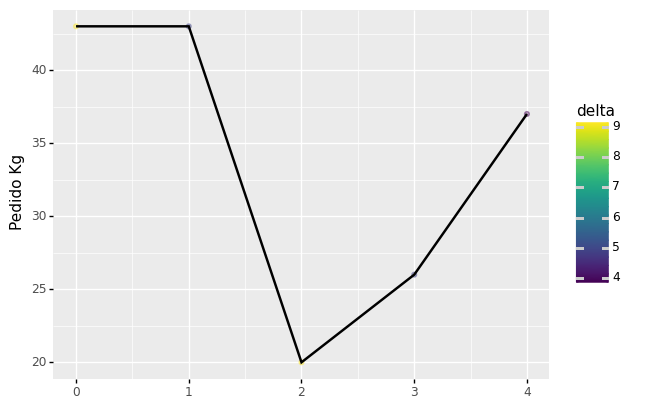

<ggplot: (197636452093)>

In [39]:
a

C:\Users\user\anaconda3\envs\Clustering\lib\site-packages\plotnine\stats\smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
C:\Users\user\anaconda3\envs\Clustering\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_smooth : Removed 5 rows containing missing values.


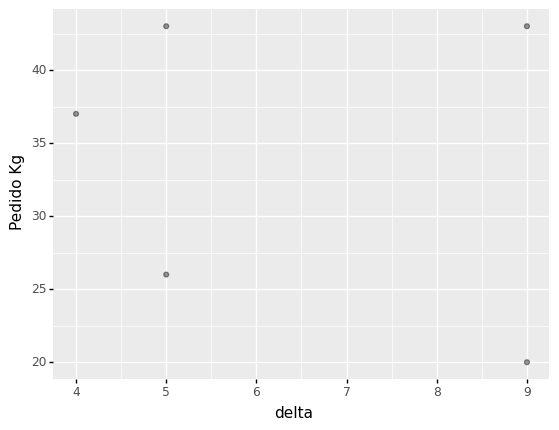

<ggplot: (197636450292)>

In [40]:
b

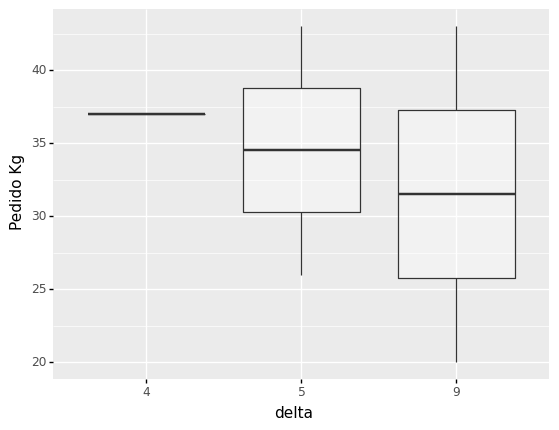

<ggplot: (197636461165)>

In [41]:
c